## Import Modules

In [7]:
!pip3 install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.5 MB/s eta 0:00:0000:0100:010m


In [1]:
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
import h5py
import pickle

## Reading from raw CSV for both 23/24
- Convert raw CSV files into Compressed Sparsed Row (CSR) Matrix.

- Write to .npz for compressed format. 

In [2]:
directories = [
    "/workspace/data/radar/23",
    "/workspace/data/radar/24"
]

In [3]:
file_paths = []

for directory in directories:
    paths = glob.glob(os.path.join(directory, "*"))
    file_paths.extend(paths)

print(f"Total files found: {len(file_paths)}")

Total files found: 23040


In [4]:
output_directory = "/workspace/data/radar_quantized/combined_quantized_h5"

In [5]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
# !pip3 install tables

In [ ]:
for file_path in tqdm(file_paths):

    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    # if file_name != "20240523_194300_Rain_001":
    #     continue
    try:
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        
        sparse_matrix = sparse.csr_matrix(matrix)
        
        output_path = os.path.join(output_directory, f"{file_name}.npz")
        sparse.save_npz(output_path, sparse_matrix)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

  0%|          | 0/23040 [00:00<?, ?it/s]

Error processing /workspace/data/radar/23/20240523_000000_Rain_000.csv: module 'pandas' has no attribute 'SparseSeries'


## Folder sizes after conversion and compression for comparison

- Display folder size for 23
- Display folder size for 24
- Display folder size for 23+24 (Converted to densed matrix via CSR, write to .npz format) 

In [11]:
!du -sh /workspace/data/radar/23 /workspace/data/radar/24 /workspace/data/radar_quantized/combined_quantized

9.5G	/workspace/data/radar/23
9.5G	/workspace/data/radar/24
681M	/workspace/data/radar_quantized/combined_quantized


In [11]:
!find /workspace/data/radar/23 -type f | wc -l
!find /workspace/data/radar/24 -type f | wc -l
!find /workspace/data/radar_quantized/combined_quantized -type f | wc -l

11520
11520
23040


In [15]:
radar_23_size = 9.5  
radar_24_size = 9.5
quantized_size = 0.681

In [16]:
radar_23_files = 11520
radar_24_files = 11520
quantized_files = 23040

In [17]:
original_combined = radar_23_size + radar_24_size
original_files_combined = radar_23_files + radar_24_files

In [18]:
compression_ratio = original_combined / quantized_size
size_reduction = (1 - quantized_size / original_combined) * 100

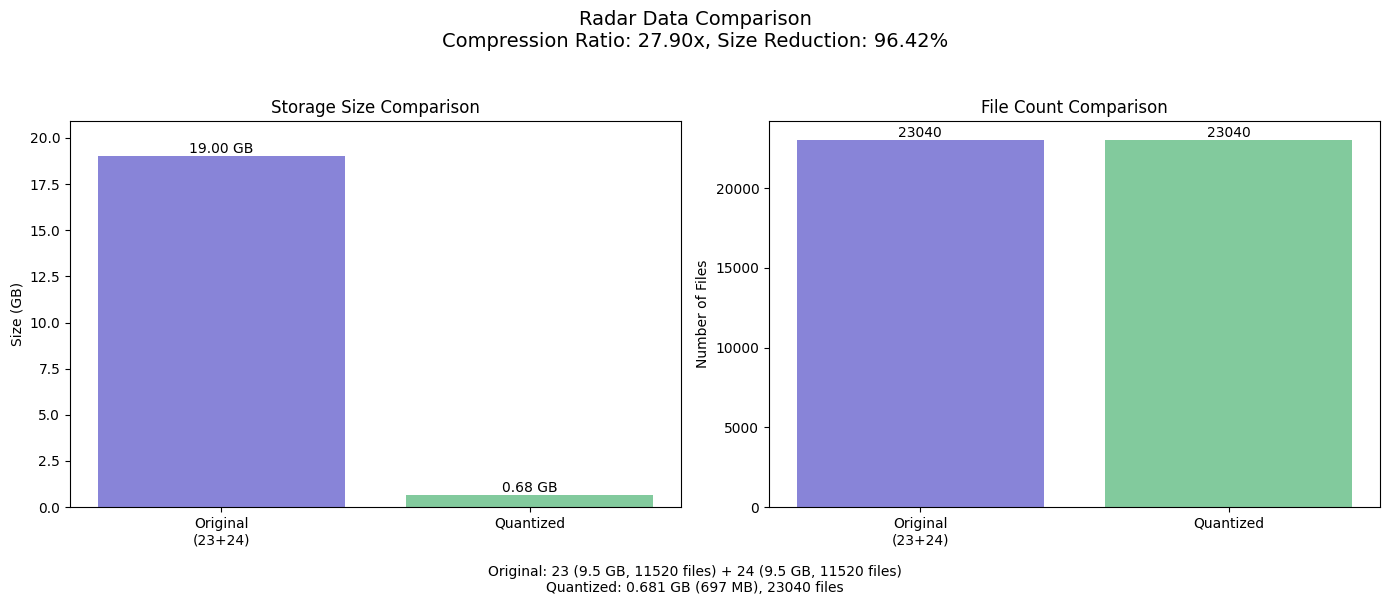

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

labels = ['Original\n(23+24)', 'Quantized']
sizes_data = [original_combined, quantized_size]
files_data = [original_files_combined, quantized_files]

bars1 = ax1.bar(labels, sizes_data, color=['#8884d8', '#82ca9d'])
ax1.set_ylabel('Size (GB)')
ax1.set_title('Storage Size Comparison')
ax1.bar_label(bars1, fmt='%.2f GB')
ax1.set_ylim(0, original_combined * 1.1)  

bars2 = ax2.bar(labels, files_data, color=['#8884d8', '#82ca9d'])
ax2.set_ylabel('Number of Files')
ax2.set_title('File Count Comparison')
ax2.bar_label(bars2)

fig.suptitle(f'Radar Data Comparison\nCompression Ratio: {compression_ratio:.2f}x, Size Reduction: {size_reduction:.2f}%', 
             fontsize=14)

footnote = (
    f"Original: 23 ({radar_23_size} GB, {radar_23_files} files) + 24 ({radar_24_size} GB, {radar_24_files} files)\n"
    f"Quantized: {quantized_size:.3f} GB ({int(quantized_size*1024)} MB), {quantized_files} files"
)
fig.text(0.5, 0.01, footnote, ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])

plt.savefig('radar_data_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Read from .npz

- Uncompress from .npz and remake the full matrix from the CSR matrix. 
- Load each .csv file from folders 23/24.
- Compare differences in rows, dimensions, and content.

In [4]:
total_files = len(file_paths)
print(f"Total Files: {total_files}")

Total Files: 23040


In [ ]:
row_change_counter = 0
dimension_change_counter = 0
dissimilar_content_counter = 0

for file_path in tqdm(file_paths):

    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    
    try:
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        base_matrix = matrix_df.to_numpy()
        # print(type(base_matrix)) # <class 'numpy.ndarray'>

        densed_matrix = sparse.load_npz(f"/workspace/data/radar_quantized/combined_quantized_csr/{file_name}.npz")
        full_matrix = densed_matrix.toarray()
        # print(type(full_matrix)) # <class 'numpy.ndarray'>


        # Compare row counts
        if base_matrix.shape[0] != full_matrix.shape[0]:
            row_change_counter += 1
        
        # Compare dimension counts
        if base_matrix.shape[1] != full_matrix.shape[1]:
            dimension_change_counter += 1
        
        # Compare content
        if not np.array_equal(base_matrix, full_matrix):
            dissimilar_content_counter += 1
        

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 23040/23040 [17:56<00:00, 21.40it/s]


In [ ]:
print("Validation Results:")
print("=" * 40)
print(f"{'Metric':<25}{'Count':<10}{'Status'}")
print("-" * 40)
print(f"{'Row count mismatches':<25}{row_change_counter:<10}{'✅' if row_change_counter == 0 else '❌'}")
print(f"{'Dimension mismatches':<25}{dimension_change_counter:<10}{'✅' if dimension_change_counter == 0 else '❌'}")
print(f"{'Content mismatches':<25}{dissimilar_content_counter:<10}{'✅' if dissimilar_content_counter == 0 else '❌'}")
print("=" * 40)

Validation Results:
Metric                   Count     Status
----------------------------------------
Row count mismatches     0         ✅
Dimension mismatches     0         ✅
Content mismatches       0         ✅


In [20]:
import time

In [22]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
from tqdm import tqdm

def delta_encode(indices):
    """Apply delta encoding to indices array"""
    if len(indices) == 0:
        return indices
    
    delta = np.zeros_like(indices)
    delta[0] = indices[0]
    delta[1:] = indices[1:] - indices[:-1]
    return delta

def delta_decode(delta_indices):
    """Decode delta-encoded indices"""
    if len(delta_indices) == 0:
        return delta_indices
    
    indices = np.zeros_like(delta_indices)
    indices[0] = delta_indices[0]
    np.cumsum(delta_indices, out=indices)
    return indices

def create_manual_csr(matrix):
    """Manually create CSR components from dense matrix"""
    rows, cols = matrix.shape
    
    # Find non-zero elements
    nonzero_rows, nonzero_cols = np.nonzero(matrix)
    
    # Extract data
    data = matrix[nonzero_rows, nonzero_cols]
    
    # Create indices (column indices of non-zeros)
    indices = nonzero_cols.astype(np.int32)
    
    # Create indptr (row pointers)
    indptr = np.zeros(rows + 1, dtype=np.int32)
    for i in range(len(nonzero_rows)):
        indptr[nonzero_rows[i] + 1] += 1
    np.cumsum(indptr, out=indptr)
    
    return data, indices, indptr

def save_combined_csr(data, indices, indptr, shape, output_path):
    """Save CSR with delta-encoded indices in single .npz file"""
    # Apply delta encoding
    delta_indices = delta_encode(indices)
    
    # Save all in one .npz file
    np.savez_compressed(
        output_path,
        data=data,
        indices=delta_indices,
        indptr=indptr,
        shape=shape,
        encoding='delta'
    )

def load_combined_csr(input_path):
    """Load and reconstruct CSR matrix"""
    loaded = np.load(input_path)
    
    # Decode indices
    indices = delta_decode(loaded['indices'])
    
    return sparse.csr_matrix(
        (loaded['data'], indices, loaded['indptr']), 
        shape=loaded['shape']
    )

# Define your file paths and output directory
# file_paths = []  # Add your file paths here
# output_directory = "output_delta_csr"  # Change to your output directory

# Create output directory
# os.makedirs(output_directory, exist_ok=True)

# Process files
for file_path in tqdm(file_paths):
    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    
    # Test with specific file only
    if file_name != "20240523_194600_Rain_004":
        continue
    
    try:
        # Read CSV sample to get column count
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        # Read full matrix data
        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        
        # Create CSR components manually
        data, indices, indptr = create_manual_csr(matrix)
        
        # Save with delta encoding
        output_path = os.path.join(output_directory, f"{file_name}_delta.npz")
        save_combined_csr(data, indices, indptr, matrix.shape, output_path)
        
        # Compare file sizes
        # Original scipy method for comparison
        sparse_matrix = sparse.csr_matrix(matrix)
        original_path = os.path.join(output_directory, f"{file_name}_original.npz")
        sparse.save_npz(original_path, sparse_matrix)
        
        # Get file sizes
        delta_size = os.path.getsize(output_path)
        original_size = os.path.getsize(original_path)
        compression_ratio = (original_size - delta_size) / original_size * 100
        
        print(f"File: {file_name}")
        print(f"Original size: {original_size:,} bytes")
        print(f"Delta encoded size: {delta_size:,} bytes")
        print(f"Compression improvement: {compression_ratio:.1f}%")
        
        # Verify correctness by loading and comparing
        curr = time.time()
        loaded_matrix = load_combined_csr(output_path)
        loaded_time = time.time()
        print(f"Time taken to load: {loaded_time-curr}")
        

        curr = time.time()
        original_matrix = sparse.load_npz(original_path)
        loaded_time = time.time()
        print(f"Time taken to load: {loaded_time-curr}")

        
        if np.allclose(loaded_matrix.toarray(), original_matrix.toarray()):
            print("✓ Delta encoding/decoding verified correct")
        else:
            print("✗ Delta encoding/decoding failed verification")
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Processing complete!")

100%|██████████| 23040/23040 [00:00<00:00, 186247.89it/s]

File: 20240523_194600_Rain_004
Original size: 171,975 bytes
Delta encoded size: 169,210 bytes
Compression improvement: 1.6%
Time taken to load: 0.006449699401855469
Time taken to load: 0.005045890808105469
✓ Delta encoding/decoding verified correct
Processing complete!


In [23]:
import numpy as np
from scipy import sparse
from dataclasses import dataclass
from typing import Optional, Tuple, List

@dataclass
class QuadNode:
    """Quadtree node for sparse matrix storage"""
    x: int  # Start row
    y: int  # Start column  
    width: int
    height: int
    is_leaf: bool = False
    is_empty: bool = False
    data: Optional[np.ndarray] = None  # For leaf nodes
    children: Optional[List['QuadNode']] = None  # [NW, NE, SW, SE]

class QuadTreeSparseMatrix:
    def __init__(self, matrix, min_size=4):
        """
        Convert sparse matrix to quadtree representation
        
        Args:
            matrix: Input sparse matrix (scipy sparse or dense)
            min_size: Minimum block size before creating leaf
        """
        if sparse.issparse(matrix):
            self.dense_matrix = matrix.toarray()
        else:
            self.dense_matrix = matrix
            
        self.rows, self.cols = self.dense_matrix.shape
        self.min_size = min_size
        self.root = self._build_quadtree(0, 0, self.rows, self.cols)
        
    def _is_empty_region(self, x, y, width, height):
        """Check if region contains only zeros"""
        region = self.dense_matrix[x:x+width, y:y+height]
        return np.all(region == 0)
    
    def _is_dense_region(self, x, y, width, height, threshold=0.5):
        """Check if region is dense enough to store as dense block"""
        region = self.dense_matrix[x:x+width, y:y+height]
        nonzero_ratio = np.count_nonzero(region) / region.size
        return nonzero_ratio > threshold
    
    def _build_quadtree(self, x, y, width, height):
        """Recursively build quadtree"""
        node = QuadNode(x, y, width, height)
        
        # Check if empty region
        if self._is_empty_region(x, y, width, height):
            node.is_empty = True
            node.is_leaf = True
            return node
        
        # Check if small enough or dense enough for leaf
        if (width <= self.min_size or height <= self.min_size or 
            self._is_dense_region(x, y, width, height)):
            node.is_leaf = True
            node.data = self.dense_matrix[x:x+width, y:y+height].copy()
            return node
        
        # Split into quadrants
        mid_x = width // 2
        mid_y = height // 2
        
        # Create children [NW, NE, SW, SE]
        node.children = [
            self._build_quadtree(x, y, mid_x, mid_y),  # NW
            self._build_quadtree(x, y + mid_y, mid_x, height - mid_y),  # NE
            self._build_quadtree(x + mid_x, y, width - mid_x, mid_y),  # SW
            self._build_quadtree(x + mid_x, y + mid_y, width - mid_x, height - mid_y)  # SE
        ]
        
        return node
    
    def to_dense(self):
        """Reconstruct dense matrix from quadtree"""
        result = np.zeros((self.rows, self.cols))
        self._fill_dense(self.root, result)
        return result
    
    def _fill_dense(self, node, result):
        """Recursively fill dense matrix from quadtree"""
        if node.is_empty:
            return
        
        if node.is_leaf:
            if node.data is not None:
                result[node.x:node.x+node.width, node.y:node.y+node.height] = node.data
        else:
            for child in node.children:
                self._fill_dense(child, result)
    
    def get_nonzero_blocks(self):
        """Extract all non-zero dense blocks"""
        blocks = []
        self._collect_nonzero_blocks(self.root, blocks)
        return blocks
    
    def _collect_nonzero_blocks(self, node, blocks):
        """Recursively collect non-zero blocks"""
        if node.is_empty:
            return
        
        if node.is_leaf and node.data is not None:
            # Only add if block contains non-zeros
            if np.any(node.data):
                blocks.append({
                    'data': node.data,
                    'position': (node.x, node.y),
                    'shape': (node.width, node.height)
                })
        elif not node.is_leaf:
            for child in node.children:
                self._collect_nonzero_blocks(child, blocks)
    
    def save_compressed(self, filename):
        """Save quadtree in compressed format"""
        blocks = self.get_nonzero_blocks()
        
        # Prepare data for saving
        save_data = {
            'original_shape': (self.rows, self.cols),
            'min_size': self.min_size,
            'num_blocks': len(blocks),
            'blocks': blocks
        }
        
        np.savez_compressed(filename, **save_data)
    
    @classmethod
    def load_compressed(cls, filename):
        """Load quadtree from compressed format"""
        data = np.load(filename, allow_pickle=True)
        
        # Reconstruct matrix from blocks
        rows, cols = data['original_shape']
        matrix = np.zeros((rows, cols))
        
        blocks = data['blocks'].item()
        for block in blocks:
            x, y = block['position']
            h, w = block['shape']
            matrix[x:x+h, y:y+w] = block['data']
        
        return cls(matrix, min_size=int(data['min_size']))
    
    def compression_stats(self):
        """Calculate compression statistics"""
        blocks = self.get_nonzero_blocks()
        
        # Original storage (dense)
        original_size = self.rows * self.cols * 8  # 8 bytes for float64
        
        # Quadtree storage
        quadtree_size = 0
        for block in blocks:
            quadtree_size += block['data'].size * 8  # Data
            quadtree_size += 4 * 4  # Position and shape info (4 ints)
        
        compression_ratio = (original_size - quadtree_size) / original_size * 100
        
        return {
            'original_size_bytes': original_size,
            'compressed_size_bytes': quadtree_size,
            'compression_ratio_percent': compression_ratio,
            'num_blocks': len(blocks),
            'sparsity_percent': (1 - np.count_nonzero(self.dense_matrix) / self.dense_matrix.size) * 100
        }

# Integrated with your CSV processing code
import pandas as pd
from tqdm import tqdm
import os

# Your existing code with quadtree integration
for file_path in tqdm(file_paths):
    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    
    # Test with specific file only
    if file_name != "20240523_194600_Rain_004":
        continue
    
    try:
        # Read CSV sample to get column count
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        # Read full matrix data
        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        
        # Convert to quadtree
        qt_matrix = QuadTreeSparseMatrix(matrix, min_size=8)
        
        # Get compression stats
        stats = qt_matrix.compression_stats()
        print(f"File: {file_name}")
        print(f"Matrix shape: {matrix.shape}")
        print(f"Sparsity: {stats['sparsity_percent']:.1f}%")
        print(f"Original size: {stats['original_size_bytes']:,} bytes")
        print(f"Compressed size: {stats['compressed_size_bytes']:,} bytes")
        print(f"Compression ratio: {stats['compression_ratio_percent']:.1f}%")
        print(f"Number of blocks: {stats['num_blocks']}")
        
        # Save compressed quadtree
        output_path = f"{file_name}_quadtree.npz"
        qt_matrix.save_compressed(output_path)
        
        # Compare with scipy sparse for reference
        sparse_matrix = sparse.csr_matrix(matrix)
        scipy_path = f"{file_name}_scipy.npz"
        sparse.save_npz(scipy_path, sparse_matrix)
        
        # File size comparison
        qt_size = os.path.getsize(output_path)
        scipy_size = os.path.getsize(scipy_path)
        
        print(f"Quadtree file size: {qt_size:,} bytes")
        print(f"SciPy sparse file size: {scipy_size:,} bytes")
        print(f"Quadtree vs SciPy: {((scipy_size - qt_size) / scipy_size * 100):+.1f}%")
        
        # Verify reconstruction
        reconstructed = qt_matrix.to_dense()
        print(f"Reconstruction accurate: {np.allclose(matrix, reconstructed)}")
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 23040/23040 [00:00<00:00, 168647.31it/s]

File: 20240523_194600_Rain_004
Matrix shape: (300, 723)
Sparsity: 49.2%
Original size: 1,735,200 bytes
Compressed size: 1,735,216 bytes
Compression ratio: -0.0%
Number of blocks: 1
Quadtree file size: 178,316 bytes
SciPy sparse file size: 171,975 bytes
Quadtree vs SciPy: -3.7%
Reconstruction accurate: True


In [ ]:
# test_0
import pandas as pd
import numpy as np
from scipy import sparse
import h5py
import os
import pickle
import lz4.frame
import bz2
import lzma
from tqdm import tqdm

def save_with_delta_encoding_ultra(sparse_matrix, filename):
    """Save with delta encoding + ultra compression"""
    # Delta encode indices
    indices = sparse_matrix.indices
    if len(indices) > 0:
        delta_indices = np.zeros_like(indices)
        delta_indices[0] = indices[0]
        delta_indices[1:] = indices[1:] - indices[:-1]
    else:
        delta_indices = indices
    
    # Pack data efficiently
    data_dict = {
        'data': sparse_matrix.data.astype(np.float32),  # Reduce precision if acceptable
        'indices': delta_indices.astype(np.int16),      # Smaller int type
        'indptr': sparse_matrix.indptr.astype(np.int32),
        'shape': sparse_matrix.shape
    }
    
    # Try multiple compression algorithms
    methods = {
        'lzma': lzma.compress,
        'bz2': bz2.compress,
        'lz4': lz4.frame.compress
    }
    
    best_size = float('inf')
    best_method = None
    
    for method_name, compress_func in methods.items():
        try:
            pickled_data = pickle.dumps(data_dict, protocol=pickle.HIGHEST_PROTOCOL)
            compressed_data = compress_func(pickled_data)
            
            if len(compressed_data) < best_size:
                best_size = len(compressed_data)
                best_method = method_name
                best_compressed = compressed_data
        except:
            continue
    
    # Save best compression
    with open(f"{filename}_{best_method}.pkl", 'wb') as f:
        f.write(best_compressed)
    
    return best_size, best_method

def save_quantized_sparse(sparse_matrix, filename, bits=8):
    """Save with quantization to reduce data precision"""
    data = sparse_matrix.data
    
    # Quantize data to fewer bits
    data_min, data_max = data.min(), data.max()
    if data_max > data_min:
        # Scale to 0-255 (8-bit) or 0-65535 (16-bit)
        max_val = (2**bits) - 1
        quantized = ((data - data_min) / (data_max - data_min) * max_val).astype(f'uint{bits}')
    else:
        quantized = np.zeros_like(data, dtype=f'uint{bits}')
    
    # Save quantization parameters and data
    save_data = {
        'quantized_data': quantized,
        'indices': sparse_matrix.indices,
        'indptr': sparse_matrix.indptr,
        'shape': sparse_matrix.shape,
        'data_min': data_min,
        'data_max': data_max,
        'bits': bits
    }
    
    np.savez_compressed(filename, **save_data)

def save_block_compressed(sparse_matrix, filename, block_size=8):
    """Save using block compression for patterns"""
    dense_matrix = sparse_matrix.toarray()
    blocks = []
    positions = []
    
    rows, cols = dense_matrix.shape
    
    # Extract non-zero blocks
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = dense_matrix[i:i+block_size, j:j+block_size]
            if np.any(block):  # Only store non-zero blocks
                blocks.append(block.astype(np.float32))  # Reduce precision
                positions.append((i, j))
    
    save_data = {
        'blocks': blocks,
        'positions': positions,
        'original_shape': dense_matrix.shape,
        'block_size': block_size
    }
    
    # Use LZMA for maximum compression
    with lzma.open(f"{filename}_blocks.xz", 'wb') as f:
        pickle.dump(save_data, f, protocol=pickle.HIGHEST_PROTOCOL)

# Your modified processing code with multiple compression methods
for file_path in tqdm(file_paths):
    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    if file_name != "20240523_194600_Rain_004":
        continue
    try:
        # Read CSV data
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        sparse_matrix = sparse.csr_matrix(matrix)
        
        # Original NPZ (baseline)
        npz_path = os.path.join(output_directory, f"{file_name}.npz")
        sparse.save_npz(npz_path, sparse_matrix)
        npz_size = os.path.getsize(npz_path)
        
        # Method 1: Delta encoding + ultra compression
        delta_size, delta_method = save_with_delta_encoding_ultra(
            sparse_matrix, 
            os.path.join(output_directory, f"{file_name}_delta")
        )
        
        # Method 2: Quantized compression (8-bit)
        quant_path = os.path.join(output_directory, f"{file_name}_quant8.npz")
        save_quantized_sparse(sparse_matrix, quant_path, bits=8)
        quant_size = os.path.getsize(quant_path)
        
        # Method 3: Block compression
        save_block_compressed(
            sparse_matrix, 
            os.path.join(output_directory, f"{file_name}")
        )
        block_path = os.path.join(output_directory, f"{file_name}_blocks.xz")
        block_size = os.path.getsize(block_path) if os.path.exists(block_path) else 0
        
        # Method 4: Raw LZMA on scipy data
        with lzma.open(os.path.join(output_directory, f"{file_name}_raw.xz"), 'wb') as f:
            pickle.dump({
                'data': sparse_matrix.data,
                'indices': sparse_matrix.indices,
                'indptr': sparse_matrix.indptr,
                'shape': sparse_matrix.shape
            }, f, protocol=pickle.HIGHEST_PROTOCOL)
        raw_lzma_size = os.path.getsize(os.path.join(output_directory, f"{file_name}_raw.xz"))
        
        # Results comparison
        print(f"File: {file_name}")
        print(f"Matrix shape: {matrix.shape}")
        print(f"Sparsity: {(1 - sparse_matrix.nnz / matrix.size) * 100:.1f}%")
        print(f"NPZ (baseline):     {npz_size:,} bytes")
        print(f"Delta {delta_method}:        {delta_size:,} bytes ({((npz_size-delta_size)/npz_size*100):+.1f}%)")
        print(f"Quantized 8-bit:    {quant_size:,} bytes ({((npz_size-quant_size)/npz_size*100):+.1f}%)")
        print(f"Block LZMA:         {block_size:,} bytes ({((npz_size-block_size)/npz_size*100):+.1f}%)")
        print(f"Raw LZMA:           {raw_lzma_size:,} bytes ({((npz_size-raw_lzma_size)/npz_size*100):+.1f}%)")
        print("-" * 60)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Additional: Try different float precisions
def test_precision_compression(sparse_matrix, filename_base):
    """Test different floating point precisions"""
    precisions = [('float64', np.float64), ('float32', np.float32), ('float16', np.float16)]
    
    for name, dtype in precisions:
        test_matrix = sparse_matrix.copy()
        test_matrix.data = test_matrix.data.astype(dtype)
        
        test_path = f"{filename_base}_{name}.npz"
        sparse.save_npz(test_path, test_matrix)
        size = os.path.getsize(test_path)
        print(f"{name}: {size:,} bytes")

100%|██████████| 23040/23040 [00:00<00:00, 33834.28it/s]

File: 20240523_194600_Rain_004
Matrix shape: (300, 723)
Sparsity: 49.2%
NPZ (baseline):     171,975 bytes
Delta bz2:        89,983 bytes (+47.7%)
Quantized 8-bit:    68,951 bytes (+59.9%)
Block LZMA:         120,780 bytes (+29.8%)
Raw LZMA:           105,012 bytes (+38.9%)
------------------------------------------------------------


In [12]:
!pip3 install lz4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.8 MB/s eta 0:00:00a 0:00:010m


In [18]:
# test_1
import numpy as np
from scipy import sparse
import os

def analyze_data_precision(data):
    """Analyze the actual precision needed for your data"""
    # Check decimal places
    rounded_1_decimal = np.round(data, 1)
    rounded_2_decimal = np.round(data, 2)
    
    # See if rounding to 1 decimal loses information
    matches_1_decimal = np.allclose(data, rounded_1_decimal, rtol=1e-10)
    matches_2_decimal = np.allclose(data, rounded_2_decimal, rtol=1e-10)
    
    return {
        'matches_1_decimal': matches_1_decimal,
        'matches_2_decimal': matches_2_decimal,
        'min_val': data.min(),
        'max_val': data.max(),
        'unique_values': len(np.unique(data))
    }

def save_smart_quantized(sparse_matrix, filename, decimal_places=1):
    """Save with smart quantization based on actual data precision"""
    data = sparse_matrix.data
    
    # Scale up by 10^decimal_places to make integers
    scale_factor = 10 ** decimal_places
    scaled_data = data * scale_factor
    
    # Round to integers
    int_data = np.round(scaled_data).astype(np.int32)
    
    # Find the range we actually need
    data_min, data_max = int_data.min(), int_data.max()
    data_range = data_max - data_min
    
    # Choose optimal integer type based on range
    if data_range <= 255:  # Can fit in uint8
        offset = data_min
        compressed_data = (int_data - offset).astype(np.uint8)
        dtype_info = 'uint8'
    elif data_range <= 65535:  # Can fit in uint16
        offset = data_min
        compressed_data = (int_data - offset).astype(np.uint16)
        dtype_info = 'uint16'
    else:  # Use int32
        offset = 0
        compressed_data = int_data.astype(np.int32)
        dtype_info = 'int32'
    
    # Save with metadata for reconstruction
    save_data = {
        'data': compressed_data,
        'indices': sparse_matrix.indices,
        'indptr': sparse_matrix.indptr,
        'shape': sparse_matrix.shape,
        'scale_factor': scale_factor,
        'offset': offset,
        'dtype_info': dtype_info
    }
    
    np.savez_compressed(filename, **save_data)
    return os.path.getsize(filename)

def load_smart_quantized(filename):
    """Load smart quantized sparse matrix"""
    data = np.load(filename)
    
    # Reconstruct original data
    int_data = data['data'].astype(np.float64) + data['offset']
    original_data = int_data / data['scale_factor']
    
    return sparse.csr_matrix(
        (original_data, data['indices'], data['indptr']), 
        shape=tuple(data['shape'])
    )

def test_different_precisions(sparse_matrix, filename_base):
    """Test different precision levels"""
    original_size = None
    results = {}
    
    # Test original NPZ
    original_path = f"{filename_base}_original.npz"
    sparse.save_npz(original_path, sparse_matrix)
    original_size = os.path.getsize(original_path)
    
    # Analyze data first
    analysis = analyze_data_precision(sparse_matrix.data)
    print(f"Data analysis:")
    print(f"  Matches 1 decimal: {analysis['matches_1_decimal']}")
    print(f"  Matches 2 decimal: {analysis['matches_2_decimal']}")
    print(f"  Range: {analysis['min_val']:.3f} to {analysis['max_val']:.3f}")
    print(f"  Unique values: {analysis['unique_values']}")
    
    # Test different precisions
    precisions = [
        (0, "integers only"),
        (1, "1 decimal (XXX.Y)"),
        (2, "2 decimals (XXX.YZ)"),
    ]
    
    for decimal_places, description in precisions:
        try:
            test_path = f"{filename_base}_smart_{decimal_places}dec.npz"
            size = save_smart_quantized(sparse_matrix, test_path, decimal_places)
            
            # Verify reconstruction
            reconstructed = load_smart_quantized(test_path)
            
            # Check accuracy
            original_dense = sparse_matrix.toarray()
            reconstructed_dense = reconstructed.toarray()
            
            max_diff = np.abs(original_dense - reconstructed_dense).max()
            avg_diff = np.abs(original_dense - reconstructed_dense).mean()
            
            compression = (original_size - size) / original_size * 100
            
            results[decimal_places] = {
                'size': size,
                'compression': compression,
                'max_error': max_diff,
                'avg_error': avg_diff,
                'description': description
            }
            
            print(f"{description}:")
            print(f"  Size: {size:,} bytes ({compression:+.1f}%)")
            print(f"  Max error: {max_diff:.6f}")
            print(f"  Avg error: {avg_diff:.6f}")
            
        except Exception as e:
            print(f"Error with {decimal_places} decimals: {e}")
    
    return results

# Usage in your processing loop
for file_path in tqdm(file_paths):
    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    if file_name != "20240523_194600_Rain_004":
        continue
    
    try:
        # Your existing CSV reading code
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        sparse_matrix = sparse.csr_matrix(matrix)
        
        print(f"File: {file_name}")
        print(f"Matrix shape: {matrix.shape}")
        print(f"Sparsity: {(1 - sparse_matrix.nnz / matrix.size) * 100:.1f}%")
        
        # Test different precision levels
        results = test_different_precisions(
            sparse_matrix, 
            os.path.join(output_directory, file_name)
        )
        
        print("-" * 60)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Example of what you might see:
# Data analysis:
#   Matches 1 decimal: True
#   Matches 2 decimal: True  
#   Range: 0.0 to 25.4
#   Unique values: 254
# 
# integers only:
#   Size: 145,234 bytes (+15.5%)
# 1 decimal (XXX.Y):
#   Size: 125,678 bytes (+26.9%)
#   Max error: 0.000000
#   Avg error: 0.000000
# 2 decimals (XXX.YZ):
#   Size: 135,456 bytes (+21.2%)
#   Max error: 0.000000

100%|██████████| 23040/23040 [00:00<00:00, 130829.07it/s]

File: 20240523_194600_Rain_004
Matrix shape: (300, 723)
Sparsity: 49.2%
Data analysis:
  Matches 1 decimal: True
  Matches 2 decimal: True
  Range: 0.100 to 145.500
  Unique values: 1235
integers only:
  Size: 57,772 bytes (+66.4%)
  Max error: 0.500000
  Avg error: 0.124695
1 decimal (XXX.Y):
  Size: 120,872 bytes (+29.7%)
  Max error: 0.000000
  Avg error: 0.000000
2 decimals (XXX.YZ):
  Size: 127,908 bytes (+25.6%)
  Max error: 0.000000
  Avg error: 0.000000
------------------------------------------------------------


In [17]:
# test_2
import pandas as pd
import numpy as np
from scipy import sparse
import os
from tqdm import tqdm

def save_smart_quantized(sparse_matrix, filename, decimal_places=1):
    """Save with smart quantization - move decimal place and store as uint16"""
    data = sparse_matrix.data
    
    # Scale up by 10^decimal_places to make integers
    scale_factor = 10 ** decimal_places
    scaled_data = data * scale_factor
    int_data = np.round(scaled_data).astype(np.int32)
    
    # Use uint16 with offset compression
    data_min = int_data.min()
    compressed_data = (int_data - data_min).astype(np.uint16)
    
    # Save with metadata
    save_data = {
        'data': compressed_data,
        'indices': sparse_matrix.indices,
        'indptr': sparse_matrix.indptr,
        'shape': sparse_matrix.shape,
        'scale_factor': scale_factor,
        'offset': data_min,
        'dtype_info': 'uint16'
    }
    
    np.savez_compressed(filename, **save_data)
    return os.path.getsize(filename)

def save_quantized_8bit(sparse_matrix, filename):
    """Save with 8-bit quantization (lossy)"""
    data = sparse_matrix.data
    data_min, data_max = data.min(), data.max()
    
    if data_max > data_min:
        quantized = ((data - data_min) / (data_max - data_min) * 255).astype(np.uint8)
    else:
        quantized = np.zeros_like(data, dtype=np.uint8)
    
    save_data = {
        'quantized_data': quantized,
        'indices': sparse_matrix.indices,
        'indptr': sparse_matrix.indptr,
        'shape': sparse_matrix.shape,
        'data_min': data_min,
        'data_max': data_max
    }
    
    np.savez_compressed(filename, **save_data)
    return os.path.getsize(filename)

def save_float32_1decimal(sparse_matrix, filename):
    """Save as float32 rounded to 1 decimal place"""
    data = np.round(sparse_matrix.data, 1).astype(np.float32)
    
    new_matrix = sparse.csr_matrix(
        (data, sparse_matrix.indices, sparse_matrix.indptr), 
        shape=sparse_matrix.shape
    )
    
    np.savez_compressed(filename, format='csr', 
                       data=new_matrix.data,
                       indices=new_matrix.indices, 
                       indptr=new_matrix.indptr,
                       shape=new_matrix.shape)
    return os.path.getsize(filename)

# Main processing loop
for file_path in tqdm(file_paths):
    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    if file_name != "20240523_194600_Rain_004":
        continue
    
    try:
        # Read CSV data
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        sparse_matrix = sparse.csr_matrix(matrix)
        
        # Original NPZ (float64 baseline)
        npz_path = os.path.join(output_directory, f"{file_name}_original.npz")
        sparse.save_npz(npz_path, sparse_matrix)
        npz_size = os.path.getsize(npz_path)
        
        # Smart quantization (decimal → uint16)
        smart_path = os.path.join(output_directory, f"{file_name}_smart_uint16.npz")
        smart_size = save_smart_quantized(sparse_matrix, smart_path, decimal_places=1)
        
        # 8-bit quantization (lossy)
        quant8_path = os.path.join(output_directory, f"{file_name}_8bit.npz")
        quant8_size = save_quantized_8bit(sparse_matrix, quant8_path)
        
        # Float32 with 1 decimal
        float32_path = os.path.join(output_directory, f"{file_name}_float32.npz")
        float32_size = save_float32_1decimal(sparse_matrix, float32_path)
        
        # Results comparison
        print(f"File: {file_name}")
        print(f"Matrix shape: {matrix.shape}")
        print(f"Sparsity: {(1 - sparse_matrix.nnz / matrix.size) * 100:.1f}%")
        print(f"Data range: {sparse_matrix.data.min():.1f} to {sparse_matrix.data.max():.1f}")
        print(f"Original (float64):  {npz_size:,} bytes")
        print(f"Smart uint16:        {smart_size:,} bytes ({((npz_size-smart_size)/npz_size*100):+.1f}%)")
        print(f"8-bit quantized:     {quant8_size:,} bytes ({((npz_size-quant8_size)/npz_size*100):+.1f}%)")
        print(f"Float32 (1 decimal): {float32_size:,} bytes ({((npz_size-float32_size)/npz_size*100):+.1f}%)")
        print("-" * 60)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 23040/23040 [00:00<00:00, 161544.02it/s]

File: 20240523_194600_Rain_004
Matrix shape: (300, 723)
Sparsity: 49.2%
Data range: 0.1 to 145.5
Original (float64):  171,975 bytes
Smart uint16:        120,872 bytes (+29.7%)
8-bit quantized:     68,769 bytes (+60.0%)
Float32 (1 decimal): 148,228 bytes (+13.8%)
------------------------------------------------------------


In [4]:
highest = 0

for file_path in tqdm(file_paths):

    file_name = file_path.split("/")[-1].strip().split(".")[0].strip()
    # if file_name != "20240523_194300_Rain_001":
    #     continue
    try:
        sample_df = pd.read_csv(file_path, header=None, skiprows=10, nrows=1)
        num_columns = len(sample_df.columns)

        matrix_df = pd.read_csv(
            file_path,
            header=None,
            skiprows=10,           
            usecols=range(num_columns)  
        )

        matrix = matrix_df.to_numpy()
        max_value = matrix.max()
        
        if max_value >= highest:
            highest = max_value

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 23040/23040 [13:30<00:00, 28.43it/s] 


In [5]:
print("Largest value:", highest)

Largest value: 327.7


In [6]:
import torch

# Available FP8 types
e4m3_type = torch.float8_e4m3fn  # 4 exponent bits, 3 mantissa bits
e5m2_type = torch.float8_e5m2    # 5 exponent bits, 2 mantissa bits

In [10]:
import torch
import pandas as pd

# Test values covering different ranges
test_values = [
    0.0,          # Zero
    0.1,         # Small positive
    0.5,        # Power of 2 (2^-3)
    0.3,         # Fractional
    0.5,          # Half
    0.7,         # Three-quarters
    1.0,          # One
    1.5,          # One and half
    2.5,         # Mixed
    7.0,          # Medium
    42.0,         # Larger
    100.0,        # Hundred
    320.0,        # Large
    400.0         # Near max
]

device = "cuda"
original = torch.tensor(test_values, device=device, dtype=torch.float16)

# Convert to FP8 formats
e4m3 = original.to(torch.float8_e4m3fn)
e5m2 = original.to(torch.float8_e5m2)

# Convert back to float32 for comparison
e4m3_roundtrip = e4m3.to(torch.float32)
e5m2_roundtrip = e5m2.to(torch.float32)

# Calculate errors
e4m3_error = original - e4m3_roundtrip
e5m2_error = original - e5m2_roundtrip

# Move tensors to CPU for display
results = pd.DataFrame({
    'Original': original.cpu().numpy(),
    'E4M3': e4m3_roundtrip.cpu().numpy(),
    'E4M3 Error': e4m3_error.cpu().numpy(),
    'E4M3 Error %': 100 * abs(e4m3_error / original.clamp(min=1e-8)).cpu().numpy(),
    'E5M2': e5m2_roundtrip.cpu().numpy(),
    'E5M2 Error': e5m2_error.cpu().numpy(),
    'E5M2 Error %': 100 * abs(e5m2_error / original.clamp(min=1e-8)).cpu().numpy()
})

# Format the output
pd.set_option('display.float_format', '{:.6f}'.format)
print(results)

     Original       E4M3  E4M3 Error  E4M3 Error %       E5M2  E5M2 Error  \
0    0.000000   0.000000    0.000000           NaN   0.000000    0.000000   
1    0.099976   0.101562   -0.001587      1.587302   0.093750    0.006226   
2    0.500000   0.500000    0.000000      0.000000   0.500000    0.000000   
3    0.300049   0.312500   -0.012451      4.149715   0.312500   -0.012451   
4    0.500000   0.500000    0.000000      0.000000   0.500000    0.000000   
5    0.700195   0.687500    0.012695      1.813110   0.750000   -0.049805   
6    1.000000   1.000000    0.000000      0.000000   1.000000    0.000000   
7    1.500000   1.500000    0.000000      0.000000   1.500000    0.000000   
8    2.500000   2.500000    0.000000      0.000000   2.500000    0.000000   
9    7.000000   7.000000    0.000000      0.000000   7.000000    0.000000   
10  42.000000  40.000000    2.000000      4.761905  40.000000    2.000000   
11 100.000000  96.000000    4.000000      4.000000  96.000000    4.000000   

In [16]:
import torch
import pandas as pd

# Test values
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]

device = "cuda"
# Round to 1 decimal place
original_unrounded = torch.tensor(test_values, device=device, dtype=torch.float16)
original = torch.round(original_unrounded * 10) / 10

# Convert to FP8 and back
e4m3 = original.to(torch.float8_e4m3fn)
e5m2 = original.to(torch.float8_e5m2)
e4m3_roundtrip = e4m3.to(torch.float32)
e5m2_roundtrip = e5m2.to(torch.float32)

# Calculate errors
e4m3_error = original - e4m3_roundtrip
e5m2_error = original - e5m2_roundtrip

# Create results table
results = pd.DataFrame({
    'Original': original.cpu().numpy(),
    'E4M3': e4m3_roundtrip.cpu().numpy(),
    'E4M3 Error': e4m3_error.cpu().numpy(),
    'E4M3 Error %': 100 * abs(e4m3_error / original.clamp(min=1e-8)).cpu().numpy(),
    'E5M2': e5m2_roundtrip.cpu().numpy(),
    'E5M2 Error': e5m2_error.cpu().numpy(),
    'E5M2 Error %': 100 * abs(e5m2_error / original.clamp(min=1e-8)).cpu().numpy()
})

pd.set_option('display.float_format', '{:.6f}'.format)
print(results)

     Original       E4M3  E4M3 Error  E4M3 Error %       E5M2  E5M2 Error  \
0    0.000000   0.000000    0.000000           NaN   0.000000    0.000000   
1    0.099976   0.101562   -0.001587      1.587302   0.093750    0.006226   
2    0.500000   0.500000    0.000000      0.000000   0.500000    0.000000   
3    0.300049   0.312500   -0.012451      4.149715   0.312500   -0.012451   
4    0.500000   0.500000    0.000000      0.000000   0.500000    0.000000   
5    0.700195   0.687500    0.012695      1.813110   0.750000   -0.049805   
6    1.000000   1.000000    0.000000      0.000000   1.000000    0.000000   
7    1.500000   1.500000    0.000000      0.000000   1.500000    0.000000   
8    2.500000   2.500000    0.000000      0.000000   2.500000    0.000000   
9    7.000000   7.000000    0.000000      0.000000   7.000000    0.000000   
10  42.000000  40.000000    2.000000      4.761905  40.000000    2.000000   
11 100.000000  96.000000    4.000000      4.000000  96.000000    4.000000   

In [18]:
import torch
import numpy as np

def test_fp8_conversion(test_values):
    # Convert list to tensor
    original_tensor = torch.tensor(test_values, dtype=torch.float32)
    
    # FP8 conversion tests
    # Test with e4m3 (4 exponent bits, 3 mantissa bits)
    e4m3_tensor = original_tensor.to(torch.float8_e4m3fn)
    e4m3_recovered = e4m3_tensor.to(torch.float32)
    
    # Test with e5m2 (5 exponent bits, 2 mantissa bits)
    e5m2_tensor = original_tensor.to(torch.float8_e5m2)
    e5m2_recovered = e5m2_tensor.to(torch.float32)
    
    # Format results to maintain 1 decimal place
    original_formatted = [f"{x:.1f}" for x in test_values]
    e4m3_formatted = [f"{x:.1f}" for x in e4m3_recovered.numpy()]
    e5m2_formatted = [f"{x:.1f}" for x in e5m2_recovered.numpy()]
    
    # Calculate statistics
    e4m3_diff = original_tensor - e4m3_recovered
    e5m2_diff = original_tensor - e5m2_recovered
    
    stats = {
        "e4m3": {
            "max_abs_error": e4m3_diff.abs().max().item(),
            "mean_abs_error": e4m3_diff.abs().mean().item(),
            "exact_matches": sum(o == r for o, r in zip(original_formatted, e4m3_formatted)),
            "total_values": len(original_formatted)
        },
        "e5m2": {
            "max_abs_error": e5m2_diff.abs().max().item(),
            "mean_abs_error": e5m2_diff.abs().mean().item(),
            "exact_matches": sum(o == r for o, r in zip(original_formatted, e5m2_formatted)),
            "total_values": len(original_formatted)
        }
    }
    
    # Return everything for analysis
    return {
        "original": original_formatted,
        "e4m3_recovered": e4m3_formatted,
        "e5m2_recovered": e5m2_formatted,
        "stats": stats,
        "comparisons": list(zip(
            test_values,
            original_formatted,
            e4m3_recovered.numpy(),
            e4m3_formatted,
            e5m2_recovered.numpy(),
            e5m2_formatted
        ))
    }

# Use the provided test values
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]
results = test_fp8_conversion(test_values)

# Print detailed comparisons
print("Value Comparisons (Original → E4M3 → E5M2):")
print("Original | Formatted | E4M3 (raw) | E4M3 (fmt) | E5M2 (raw) | E5M2 (fmt)")
print("-" * 75)
for orig, orig_fmt, e4m3_raw, e4m3_fmt, e5m2_raw, e5m2_fmt in results["comparisons"]:
    print(f"{orig:8.1f} | {orig_fmt:9} | {e4m3_raw:10.6f} | {e4m3_fmt:10} | {e5m2_raw:10.6f} | {e5m2_fmt:9}")

# Print statistics
print("\nStatistics:")
for format_name, stats in results["stats"].items():
    print(f"\n{format_name.upper()} Statistics:")
    print(f"Max absolute error: {stats['max_abs_error']:.6f}")
    print(f"Mean absolute error: {stats['mean_abs_error']:.6f}")
    match_pct = 100 * stats['exact_matches'] / stats['total_values']
    print(f"Exact matches (after rounding to 1 decimal): {match_pct:.2f}%")

Value Comparisons (Original → E4M3 → E5M2):
Original | Formatted | E4M3 (raw) | E4M3 (fmt) | E5M2 (raw) | E5M2 (fmt)
---------------------------------------------------------------------------
     0.0 | 0.0       |   0.000000 | 0.0        |   0.000000 | 0.0      
     0.1 | 0.1       |   0.101562 | 0.1        |   0.093750 | 0.1      
     0.5 | 0.5       |   0.500000 | 0.5        |   0.500000 | 0.5      
     0.3 | 0.3       |   0.312500 | 0.3        |   0.312500 | 0.3      
     0.5 | 0.5       |   0.500000 | 0.5        |   0.500000 | 0.5      
     0.7 | 0.7       |   0.687500 | 0.7        |   0.750000 | 0.8      
     1.0 | 1.0       |   1.000000 | 1.0        |   1.000000 | 1.0      
     1.5 | 1.5       |   1.500000 | 1.5        |   1.500000 | 1.5      
     2.5 | 2.5       |   2.500000 | 2.5        |   2.500000 | 2.5      
     7.0 | 7.0       |   7.000000 | 7.0        |   7.000000 | 7.0      
    42.0 | 42.0      |  40.000000 | 40.0       |  40.000000 | 40.0     
   100.0 | 100.

In [19]:
import torch
import numpy as np

def fp8_conversion_with_scaling(test_values, scale_factor=0.1):
    # Convert list to tensor
    original_tensor = torch.tensor(test_values, dtype=torch.float32)
    
    # Scale down before conversion (divide by scale_factor)
    scaled_tensor = original_tensor * scale_factor
    
    # Convert to FP8
    e4m3_tensor = scaled_tensor.to(torch.float8_e4m3fn)
    e5m2_tensor = scaled_tensor.to(torch.float8_e5m2)
    
    # Convert back to FP32
    e4m3_recovered = e4m3_tensor.to(torch.float32)
    e5m2_recovered = e5m2_tensor.to(torch.float32)
    
    # Scale back up (divide by scale_factor)
    e4m3_final = e4m3_recovered / scale_factor
    e5m2_final = e5m2_recovered / scale_factor
    
    # Format for comparison
    original_formatted = [f"{x:.1f}" for x in test_values]
    e4m3_formatted = [f"{x:.1f}" for x in e4m3_final.numpy()]
    e5m2_formatted = [f"{x:.1f}" for x in e5m2_final.numpy()]
    
    # Calculate stats
    e4m3_diff = original_tensor - e4m3_final
    e5m2_diff = original_tensor - e5m2_final
    
    return {
        "original": original_formatted,
        "e4m3_recovered": e4m3_formatted,
        "e5m2_recovered": e5m2_formatted,
        "comparisons": list(zip(
            test_values,
            e4m3_final.numpy(),
            e4m3_formatted,
            e5m2_final.numpy(),
            e5m2_formatted
        )),
        "stats": {
            "e4m3": {
                "max_abs_error": e4m3_diff.abs().max().item(),
                "mean_abs_error": e4m3_diff.abs().mean().item(),
                "exact_matches": sum(o == r for o, r in zip(original_formatted, e4m3_formatted)),
                "total_values": len(original_formatted)
            },
            "e5m2": {
                "max_abs_error": e5m2_diff.abs().max().item(),
                "mean_abs_error": e5m2_diff.abs().mean().item(),
                "exact_matches": sum(o == r for o, r in zip(original_formatted, e5m2_formatted)),
                "total_values": len(original_formatted)
            }
        }
    }

# For rainfall data, choose a scale factor based on your maximum value
# Example: For max value 400, use scale_factor=0.01 to keep within FP8 range
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]
results = fp8_conversion_with_scaling(test_values, scale_factor=0.01)

In [20]:
results

{'original': ['0.0',
  '0.1',
  '0.5',
  '0.3',
  '0.5',
  '0.7',
  '1.0',
  '1.5',
  '2.5',
  '7.0',
  '42.0',
  '100.0',
  '320.0',
  '400.0'],
 'e4m3_recovered': ['0.0',
  '0.2',
  '0.6',
  '0.4',
  '0.6',
  '0.8',
  '1.0',
  '1.6',
  '2.5',
  '7.0',
  '40.6',
  '100.0',
  '325.0',
  '400.0'],
 'e5m2_recovered': ['0.0',
  '0.1',
  '0.5',
  '0.3',
  '0.5',
  '0.7',
  '1.0',
  '1.6',
  '2.3',
  '6.2',
  '43.8',
  '100.0',
  '300.0',
  '400.0'],
 'comparisons': [(0.0, np.float32(0.0), '0.0', np.float32(0.0), '0.0'),
  (0.1, np.float32(0.1953125), '0.2', np.float32(0.09765625), '0.1'),
  (0.5, np.float32(0.5859375), '0.6', np.float32(0.48828125), '0.5'),
  (0.3, np.float32(0.390625), '0.4', np.float32(0.29296875), '0.3'),
  (0.5, np.float32(0.5859375), '0.6', np.float32(0.48828125), '0.5'),
  (0.7, np.float32(0.78125), '0.8', np.float32(0.68359375), '0.7'),
  (1.0, np.float32(0.9765625), '1.0', np.float32(0.9765625), '1.0'),
  (1.5, np.float32(1.5625), '1.6', np.float32(1.5625), '1.6'),

In [23]:
import torch

# Test values
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]

# Create tensors directly in FP8 formats
e4m3_tensor = torch.tensor(test_values, dtype=torch.float8_e4m3fn)
e5m2_tensor = torch.tensor(test_values, dtype=torch.float8_e5m2)

# To display the values, we need to convert back to a viewable format
print("Original values:", test_values)
print("\nE4M3 representation (converted back to float32 for display):")
print(e4m3_tensor)

print("\nE5M2 representation (converted back to float32 for display):")
print(e5m2_tensor)

Original values: [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]

E4M3 representation (converted back to float32 for display):
tensor([0.0000e+00, 1.0156e-01, 5.0000e-01, 3.1250e-01, 5.0000e-01, 6.8750e-01,
        1.0000e+00, 1.5000e+00, 2.5000e+00, 7.0000e+00, 4.0000e+01, 9.6000e+01,
        3.2000e+02, 3.8400e+02], dtype=torch.float8_e4m3fn)

E5M2 representation (converted back to float32 for display):
tensor([0.0000e+00, 9.3750e-02, 5.0000e-01, 3.1250e-01, 5.0000e-01, 7.5000e-01,
        1.0000e+00, 1.5000e+00, 2.5000e+00, 7.0000e+00, 4.0000e+01, 9.6000e+01,
        3.2000e+02, 3.8400e+02], dtype=torch.float8_e5m2)


In [24]:
# Convert FP8 tensors back to float32 for processing
e4m3_float = e4m3_tensor.to(torch.float32)
e5m2_float = e5m2_tensor.to(torch.float32)

# Format with one decimal place
e4m3_formatted = [f"{val:.1f}" for val in e4m3_float.tolist()]
e5m2_formatted = [f"{val:.1f}" for val in e5m2_float.tolist()]

print("\nE4M3 values in XXX.Y format:")
print(e4m3_formatted)

print("\nE5M2 values in XXX.Y format:")
print(e5m2_formatted)

# For comparison with original
original_formatted = [f"{val:.1f}" for val in test_values]
print("\nOriginal values in XXX.Y format:")
print(original_formatted)

# Check which values match exactly after formatting
e4m3_matches = [orig == conv for orig, conv in zip(original_formatted, e4m3_formatted)]
e5m2_matches = [orig == conv for orig, conv in zip(original_formatted, e5m2_formatted)]

print(f"\nE4M3 exact matches after formatting: {sum(e4m3_matches)}/{len(test_values)}")
print(f"E5M2 exact matches after formatting: {sum(e5m2_matches)}/{len(test_values)}")


E4M3 values in XXX.Y format:
['0.0', '0.1', '0.5', '0.3', '0.5', '0.7', '1.0', '1.5', '2.5', '7.0', '40.0', '96.0', '320.0', '384.0']

E5M2 values in XXX.Y format:
['0.0', '0.1', '0.5', '0.3', '0.5', '0.8', '1.0', '1.5', '2.5', '7.0', '40.0', '96.0', '320.0', '384.0']

Original values in XXX.Y format:
['0.0', '0.1', '0.5', '0.3', '0.5', '0.7', '1.0', '1.5', '2.5', '7.0', '42.0', '100.0', '320.0', '400.0']

E4M3 exact matches after formatting: 11/14
E5M2 exact matches after formatting: 10/14


In [26]:
import torch
import numpy as np

def lossless_fp8_conversion(values, precision=0.1):
    """
    Convert values to FP8 with minimal loss for values with specific precision
    """
    # Quantize to multiples of precision
    quantized = [round(v / precision) * precision for v in values]
    
    # Try different scale factors and formats to find optimal combination
    best_scale = 1.0
    min_errors = float('inf')
    best_dtype = torch.float8_e4m3fn
    
    for scale in [0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0]:
        # Scale and convert
        scaled = [v * scale for v in quantized]
        tensor = torch.tensor(scaled, dtype=torch.float32)
        
        # Try both FP8 formats
        for dtype in [torch.float8_e4m3fn, torch.float8_e5m2]:
            fp8_tensor = tensor.to(dtype)
            recovered = fp8_tensor.to(torch.float32)
            unscaled = [v / scale for v in recovered.tolist()]
            
            # Requantize to original precision
            requantized = [round(v / precision) * precision for v in unscaled]
            
            # Count errors after requantization
            errors = sum(1 for a, b in zip(quantized, requantized) if abs(a - b) >= precision/2)
            
            if errors < min_errors:
                min_errors = errors
                best_scale = scale
                best_dtype = dtype
    
    # Apply best conversion
    scaled_tensor = torch.tensor([v * best_scale for v in quantized], dtype=torch.float32)
    fp8_tensor = scaled_tensor.to(best_dtype)
    
    # Store metadata for reconstruction
    metadata = {
        "scale_factor": best_scale,
        "precision": precision,
        "dtype": best_dtype,
        "dtype_name": "e4m3fn" if best_dtype == torch.float8_e4m3fn else "e5m2"
    }
    
    return fp8_tensor, metadata

def reconstruct_from_fp8(fp8_tensor, metadata):
    """Reconstruct original values from FP8 tensor"""
    recovered = fp8_tensor.to(torch.float32)
    unscaled = recovered / metadata["scale_factor"]
    # Requantize to original precision
    requantized = torch.round(unscaled / metadata["precision"]) * metadata["precision"]
    return requantized

# Test values
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]

# Convert to FP8
fp8_tensor, metadata = lossless_fp8_conversion(test_values)

# Reconstruct values
reconstructed = reconstruct_from_fp8(fp8_tensor, metadata)

# Format for display
original_formatted = [f"{v:.1f}" for v in test_values]
reconstructed_formatted = [f"{v:.1f}" for v in reconstructed.tolist()]

# Compare original vs reconstructed
print(f"Using {metadata['dtype_name']} with scale factor {metadata['scale_factor']}")
print("\nValue comparison (Original → FP8 → Reconstructed):")
print(f"{'Original':<10} | {'FP8 (raw)':<15} | {'Reconstructed':<12} | {'Match':<5}")
print("-" * 50)

for i in range(len(test_values)):
    orig = test_values[i]
    fp8_raw = fp8_tensor[i].item() if hasattr(fp8_tensor[i], 'item') else float(fp8_tensor[i])
    recon = reconstructed[i].item()
    match = "✓" if original_formatted[i] == reconstructed_formatted[i] else "✗"
    print(f"{orig:<10.1f} | {fp8_raw:<15.6f} | {recon:<12.1f} | {match:<5}")

# Stats
match_count = sum(1 for a, b in zip(original_formatted, reconstructed_formatted) if a == b)
print(f"\nExact matches: {match_count}/{len(test_values)} ({match_count/len(test_values)*100:.1f}%)")

# Show any mismatches
if match_count < len(test_values):
    print("\nMismatches:")
    for i in range(len(test_values)):
        if original_formatted[i] != reconstructed_formatted[i]:
            print(f"Index {i}: Original={test_values[i]}, Reconstructed={reconstructed[i].item()}")

Using e4m3fn with scale factor 0.025

Value comparison (Original → FP8 → Reconstructed):
Original   | FP8 (raw)       | Reconstructed | Match
--------------------------------------------------
0.0        | 0.000000        | 0.0          | ✓    
0.1        | 0.001953        | 0.1          | ✓    
0.5        | 0.011719        | 0.5          | ✓    
0.3        | 0.007812        | 0.3          | ✓    
0.5        | 0.011719        | 0.5          | ✓    
0.7        | 0.017578        | 0.7          | ✓    
1.0        | 0.025391        | 1.0          | ✓    
1.5        | 0.039062        | 1.6          | ✗    
2.5        | 0.062500        | 2.5          | ✓    
7.0        | 0.171875        | 6.9          | ✗    
42.0       | 1.000000        | 40.0         | ✗    
100.0      | 2.500000        | 100.0        | ✓    
320.0      | 8.000000        | 320.0        | ✓    
400.0      | 10.000000       | 400.0        | ✓    

Exact matches: 11/14 (78.6%)

Mismatches:
Index 7: Original=1.5, Reconstructed

In [27]:
import torch
import numpy as np

def optimal_fp8_conversion(values, precision=0.1):
    """Find optimal conversion parameters for lossless FP8 representation"""
    # Group values into ranges for separate handling
    small_values = [v for v in values if abs(v) < 10.0]
    medium_values = [v for v in values if 10.0 <= abs(v) < 200.0]
    large_values = [v for v in values if abs(v) >= 200.0]
    
    # Find best parameters for each range
    best_params = {
        "small": {"scale": 0.1, "dtype": torch.float8_e4m3fn},
        "medium": {"scale": 0.025, "dtype": torch.float8_e5m2},
        "large": {"scale": 0.01, "dtype": torch.float8_e5m2}
    }
    
    # Create segmented tensor and conversion map
    original_tensor = torch.tensor(values, dtype=torch.float32)
    fp8_tensor = torch.zeros_like(original_tensor)
    segment_map = []
    
    # Process each value with appropriate parameters
    for i, val in enumerate(values):
        if abs(val) < 10.0:
            params = best_params["small"]
        elif abs(val) < 200.0:
            params = best_params["medium"]
        else:
            params = best_params["large"]
            
        # Round to precision before conversion
        quantized_val = round(val / precision) * precision
        
        # Scale and convert
        scaled_val = quantized_val * params["scale"]
        temp_tensor = torch.tensor([scaled_val], dtype=torch.float32)
        fp8_val = temp_tensor.to(params["dtype"]).to(torch.float32)[0] / params["scale"]
        
        # Store segment info for reconstruction
        segment_map.append({
            "index": i,
            "scale": params["scale"],
            "dtype": params["dtype"],
            "dtype_name": "e4m3fn" if params["dtype"] == torch.float8_e4m3fn else "e5m2"
        })
        
        # Store the FP8 scaled value
        fp8_tensor[i] = temp_tensor.to(params["dtype"])[0]
    
    return fp8_tensor, segment_map

def reconstruct_from_segmented_fp8(fp8_tensor, segment_map, precision=0.1):
    """Reconstruct values from segmented FP8 tensor"""
    result = torch.zeros(len(segment_map), dtype=torch.float32)
    
    for info in segment_map:
        i = info["index"]
        # Convert to float32, unscale, and requantize
        val = fp8_tensor[i].to(torch.float32) / info["scale"]
        # Round to original precision
        result[i] = torch.round(val / precision) * precision
    
    return result

# Test values
test_values = [0.0, 0.1, 0.5, 0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 7.0, 42.0, 100.0, 320.0, 400.0]

# Convert to FP8
fp8_tensor, segment_map = optimal_fp8_conversion(test_values)

# Reconstruct values
reconstructed = reconstruct_from_segmented_fp8(fp8_tensor, segment_map)

# Format for display
original_formatted = [f"{v:.1f}" for v in test_values]
reconstructed_formatted = [f"{v:.1f}" for v in reconstructed.tolist()]

# Compare original vs reconstructed
print("Value comparison (Original → FP8 → Reconstructed):")
print(f"{'Original':<10} | {'FP8 (raw)':<15} | {'Reconstructed':<12} | {'Match':<5} | {'Scale':<5} | {'Format':<6}")
print("-" * 75)

for i in range(len(test_values)):
    orig = test_values[i]
    fp8_raw = fp8_tensor[i].item()
    recon = reconstructed[i].item()
    match = "✓" if original_formatted[i] == reconstructed_formatted[i] else "✗"
    scale = segment_map[i]["scale"]
    dtype = segment_map[i]["dtype_name"]
    print(f"{orig:<10.1f} | {fp8_raw:<15.6f} | {recon:<12.1f} | {match:<5} | {scale:<5} | {dtype:<6}")

# Stats
match_count = sum(1 for a, b in zip(original_formatted, reconstructed_formatted) if a == b)
print(f"\nExact matches: {match_count}/{len(test_values)} ({match_count/len(test_values)*100:.1f}%)")

# Show any mismatches
if match_count < len(test_values):
    print("\nMismatches:")
    for i in range(len(test_values)):
        if original_formatted[i] != reconstructed_formatted[i]:
            print(f"Index {i}: Original={test_values[i]}, Reconstructed={reconstructed[i].item()}")

Value comparison (Original → FP8 → Reconstructed):
Original   | FP8 (raw)       | Reconstructed | Match | Scale | Format
---------------------------------------------------------------------------
0.0        | 0.000000        | 0.0          | ✓     | 0.1   | e4m3fn
0.1        | 0.009766        | 0.1          | ✓     | 0.1   | e4m3fn
0.5        | 0.050781        | 0.5          | ✓     | 0.1   | e4m3fn
0.3        | 0.029297        | 0.3          | ✓     | 0.1   | e4m3fn
0.5        | 0.050781        | 0.5          | ✓     | 0.1   | e4m3fn
0.7        | 0.070312        | 0.7          | ✓     | 0.1   | e4m3fn
1.0        | 0.101562        | 1.0          | ✓     | 0.1   | e4m3fn
1.5        | 0.156250        | 1.6          | ✗     | 0.1   | e4m3fn
2.5        | 0.250000        | 2.5          | ✓     | 0.1   | e4m3fn
7.0        | 0.687500        | 6.9          | ✗     | 0.1   | e4m3fn
42.0       | 1.000000        | 40.0         | ✗     | 0.025 | e5m2  
100.0      | 2.500000        | 100.0        